# Домашнее задание ШАД МТС по теме ТВиМС 6

## Задание

Необходимо взять (или сгенерировать самому) датасет, в котором для достаточно большой целевой аудитории (абоненты или лояльные клиенты) представлены еженедельные метрики (тут на ваш выбор). Например, в течение 2-3 месяцев вы собирали, накапливали ваши данные. Далее используйте различные техники для проверки распределений ваших метрик (1 метрика - непрерывная, 2-я дискретная [можно взять бинарную]).

*Пример.* У меня есть 1 миллион юзеров Киона. Собираю по ним метрики за 12 недель (суммарное время просмотра за каждую неделю и флаг просмотра хотя бы одного фильма из какой-то категории). Далее сравниваем распределения метрик в динамике по разным неделям и делаем выводы о появлении отклонения (распределение начало изменяться или нет).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mplcyberpunk

plt.style.use('cyberpunk')

In [2]:
df = pd.read_csv('./vodclickstream_uk_movies_03.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [3]:
# Перевод datetime из строки в объект
df['datetime'] = pd.to_datetime(df['datetime'])

# Номер недели и год делаем отдельными признаками
df['week'] = df['datetime'].dt.isocalendar().week
df['year'] = df['datetime'].dt.isocalendar().year

In [4]:
# Функция расчета PSI
def psi(old_sample, new_sample, bins = 10):
    delimiters = np.histogram(new_sample, bins)[1]

    old_sample_perc = np.histogram(old_sample, delimiters)[0] / len(old_sample)
    new_sample_perc = np.histogram(new_sample, delimiters)[0] / len(new_sample)

    old_sample_perc = np.clip(old_sample_perc, a_min=0.0001, a_max=None)
    new_sample_perc = np.clip(new_sample_perc, a_min=0.0001, a_max=None)

    psi_value = (new_sample_perc - old_sample_perc) * np.log(new_sample_perc / old_sample_perc)
    return sum(psi_value)

### PSI для непрерывного кейса

В качестве метрики будем использовать суммарную длительность просмотра (duration) по пользователям

In [5]:
df_cont = df.groupby(['user_id', 'week', 'year'])['duration'].sum().reset_index()
df_cont

,user_id,week,year,duration
0,00004e2862,49,2017,0.0
1,000052a0a0,21,2017,17803.0
2,000052a0a0,22,2017,0.0
3,000052a0a0,24,2017,11723.0
4,000052a0a0,25,2017,7025.0
...,...,...,...,...
276433,fffeac83be,33,2017,92489.0
276434,fffeac83be,36,2017,3385.0
276435,fffeac83be,38,2017,173565.0
276436,ffff2c5f9e,29,2017,0.0


In [6]:
# Фильтруем год и неделю
year_to_filter = 2017
week_max = df_cont[df_cont['year'] == year_to_filter]['week'].max()

In [7]:
standart_sample = df_cont[(df_cont['year'] == year_to_filter) & (df_cont['week'] == 1)].sort_values(by='user_id', ascending=True)['duration'].to_numpy()
weeks_cont = pd.DataFrame()

for i in range(1, week_max):
    row = {}
    actual_sample = df_cont[(df_cont['year'] == year_to_filter) & (df_cont['week'] == i)].sort_values(by='user_id', ascending=True)['duration'].to_numpy()
    expected_sample = df_cont[(df_cont['year'] == year_to_filter) & (df_cont['week'] == i + 1)].sort_values(by='user_id', ascending=True)['duration'].to_numpy()
    row['week'] = i
    row['psi_with_next'] = psi(actual_sample, expected_sample).round(4)
    row['psi_with_first'] = psi(standart_sample, actual_sample).round(4)
    weeks_cont = pd.concat([weeks_cont, pd.DataFrame([row])])

weeks_cont.head(10)

,week,psi_with_next,psi_with_first
0,1,0.0407,0.0000
0,2,0.0375,0.0407
0,3,0.0614,0.0257
0,4,0.0302,0.1023
0,5,0.0740,0.1123
0,6,0.0344,0.0229
0,7,0.0173,0.0491
0,8,0.0186,0.0187
0,9,0.0132,0.0185
0,10,0.0067,0.0380


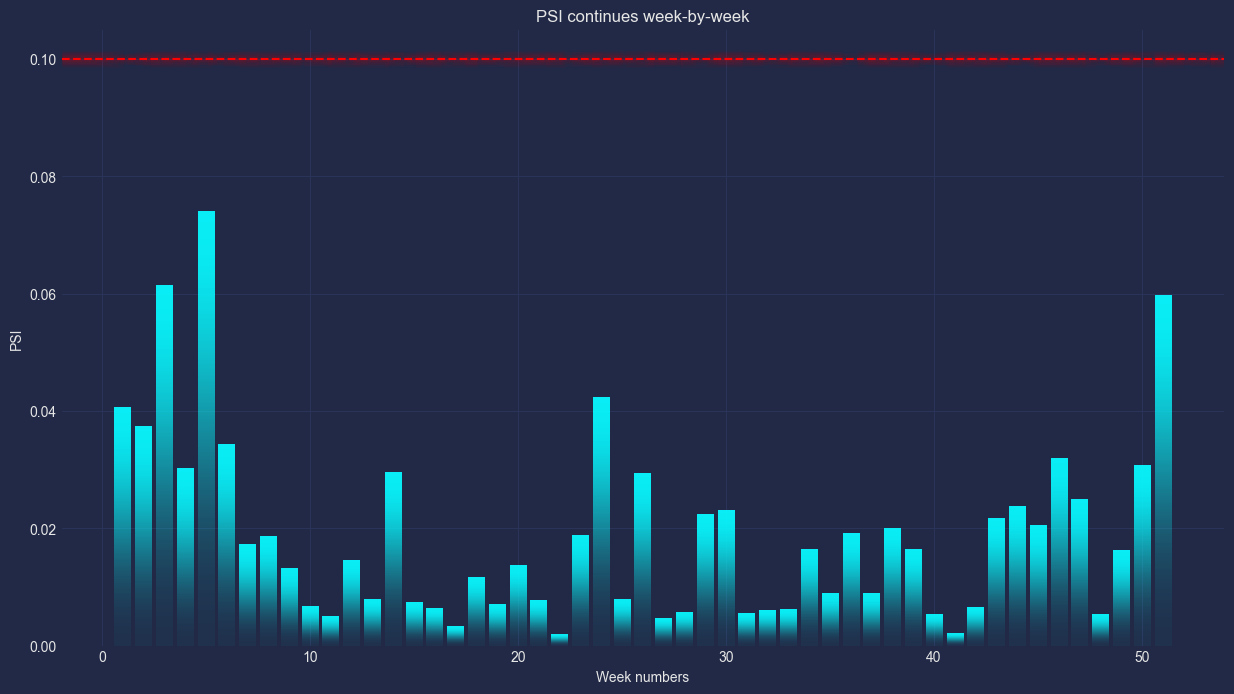

In [8]:
# Визуализация PSI по неделям
plt.figure(figsize=(15, 8))
bars = plt.bar(weeks_cont['week'], weeks_cont['psi_with_next'])
plt.axhline(y=0.1, color='red', linestyle='--')
plt.xlabel('Week numbers')
plt.ylabel('PSI')
plt.title('PSI continues week-by-week')
mplcyberpunk.add_bar_gradient(bars=bars)
mplcyberpunk.make_lines_glow()

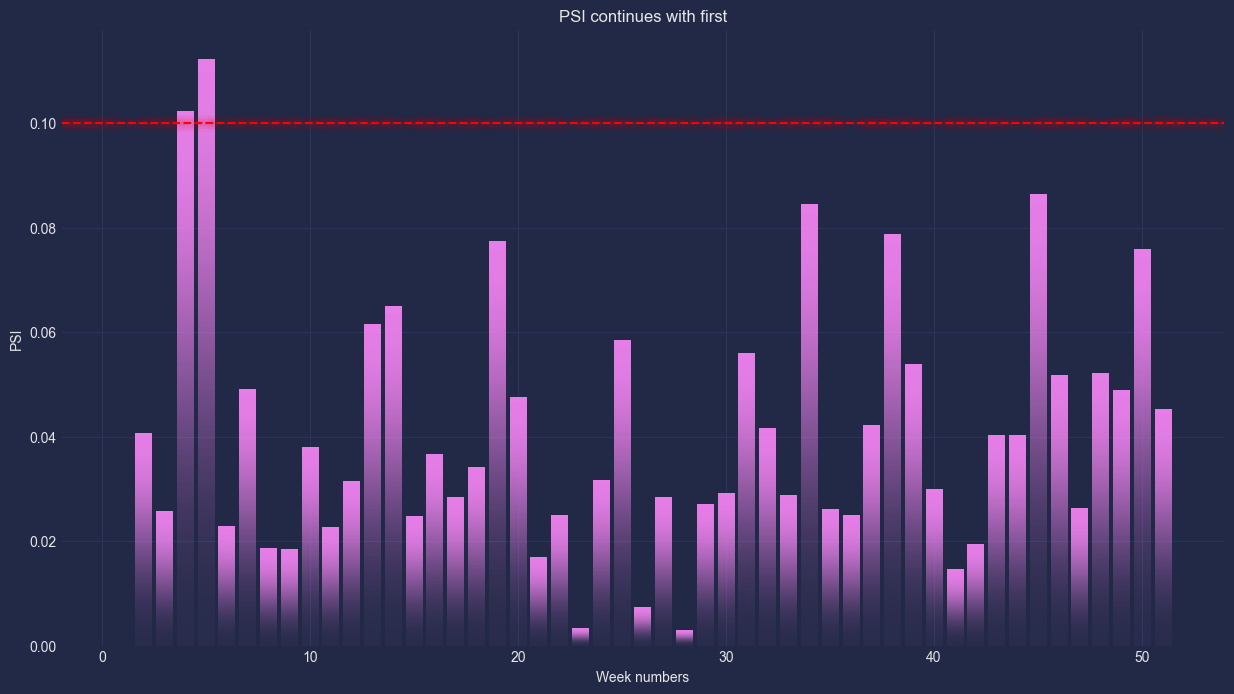

In [9]:
# Визуализация PSI с эталонным сэмплом
plt.figure(figsize=(15, 8))
bars = plt.bar(weeks_cont['week'], weeks_cont['psi_with_first'], color='violet')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.xlabel('Week numbers')
plt.ylabel('PSI')
plt.title('PSI continues with first')
mplcyberpunk.add_bar_gradient(bars=bars)
mplcyberpunk.make_lines_glow()

### PSI для дискретного кейса

В качестве метрики используем флаг просмотра хотя бы одного фильма в жанре Thriller

In [10]:
genre = 'Thriller'
df['is_genre'] = df['genres'].str.contains(genre).astype(int)
df

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,week,year,is_genre
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,52,2016,0
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,52,2016,1
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,52,2016,1
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,52,2016,0
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,52,2016,0
...,...,...,...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,26,2019,0
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,26,2019,0
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,26,2019,0
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,26,2019,0


In [11]:
df_disc = df.groupby(['user_id', 'week', 'year'])['is_genre'].sum().reset_index()
df_disc

,user_id,week,year,is_genre
0,00004e2862,49,2017,1
1,000052a0a0,21,2017,4
2,000052a0a0,22,2017,1
3,000052a0a0,24,2017,9
4,000052a0a0,25,2017,2
...,...,...,...,...
276433,fffeac83be,33,2017,0
276434,fffeac83be,36,2017,0
276435,fffeac83be,38,2017,0
276436,ffff2c5f9e,29,2017,1


In [12]:
# Фильтруем год и неделю
year_to_filter = 2017
week_max = df_disc[df_disc['year'] == year_to_filter]['week'].max()

In [13]:
standart_sample = df_disc[(df_disc['year'] == year_to_filter) & (df_disc['week'] == 1)].sort_values(by='user_id', ascending=True)['is_genre'].to_numpy()
weeks_disc = pd.DataFrame()

for i in range(1, week_max):
    row = {}
    actual_sample = df_disc[(df_disc['year'] == year_to_filter) & (df_disc['week'] == i)].sort_values(by='user_id', ascending=True)['is_genre'].to_numpy()
    expected_sample = df_disc[(df_disc['year'] == year_to_filter) & (df_disc['week'] == i + 1)].sort_values(by='user_id', ascending=True)['is_genre'].to_numpy()
    row['week'] = i
    row['psi_with_next'] = psi(actual_sample, expected_sample).round(4)
    row['psi_with_first'] = psi(standart_sample, actual_sample).round(4)
    weeks_disc = pd.concat([weeks_disc, pd.DataFrame([row])])

weeks_disc.head(10)

,week,psi_with_next,psi_with_first
0,1,0.0309,0.0000
0,2,0.0239,0.0309
0,3,0.0111,0.0459
0,4,0.0164,0.0739
0,5,0.0432,0.0564
0,6,0.0133,0.0592
0,7,0.0294,0.0491
0,8,0.0113,0.0121
0,9,0.0021,0.0297
0,10,0.0085,0.0281


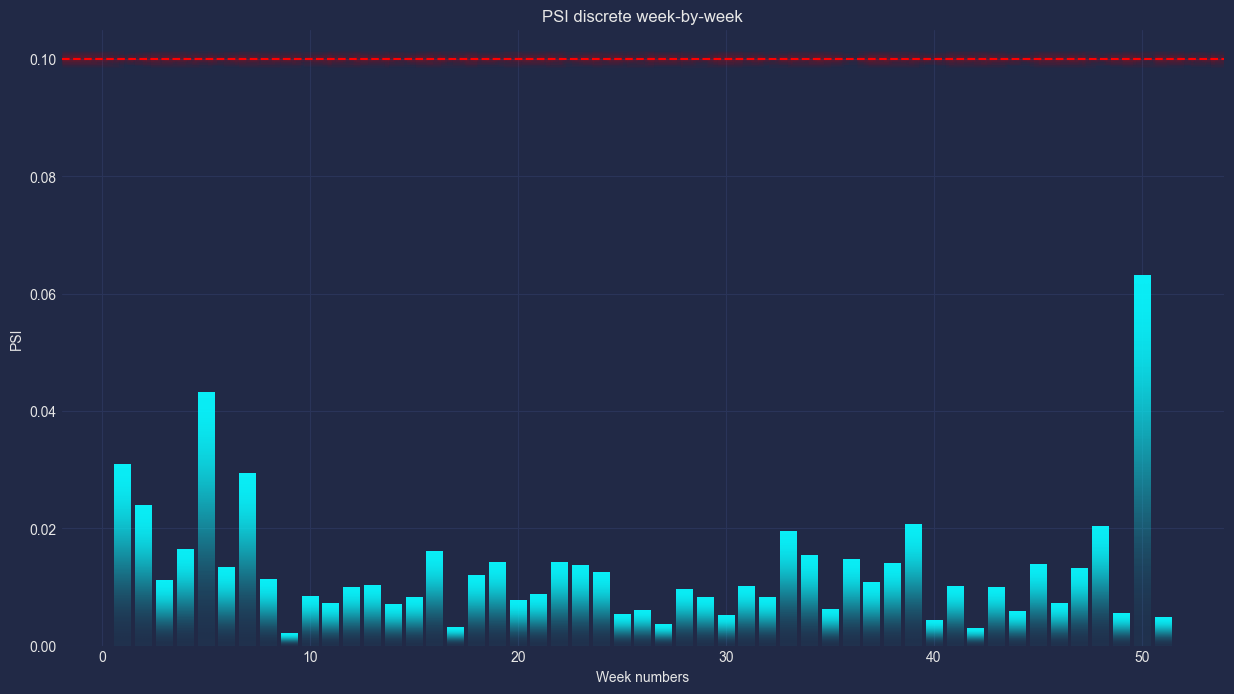

In [14]:
# Визуализация PSI по неделям
plt.figure(figsize=(15, 8))
bars = plt.bar(weeks_disc['week'], weeks_disc['psi_with_next'])
plt.axhline(y=0.1, color='red', linestyle='--')
plt.xlabel('Week numbers')
plt.ylabel('PSI')
plt.title('PSI discrete week-by-week')
mplcyberpunk.add_bar_gradient(bars=bars)
mplcyberpunk.make_lines_glow()

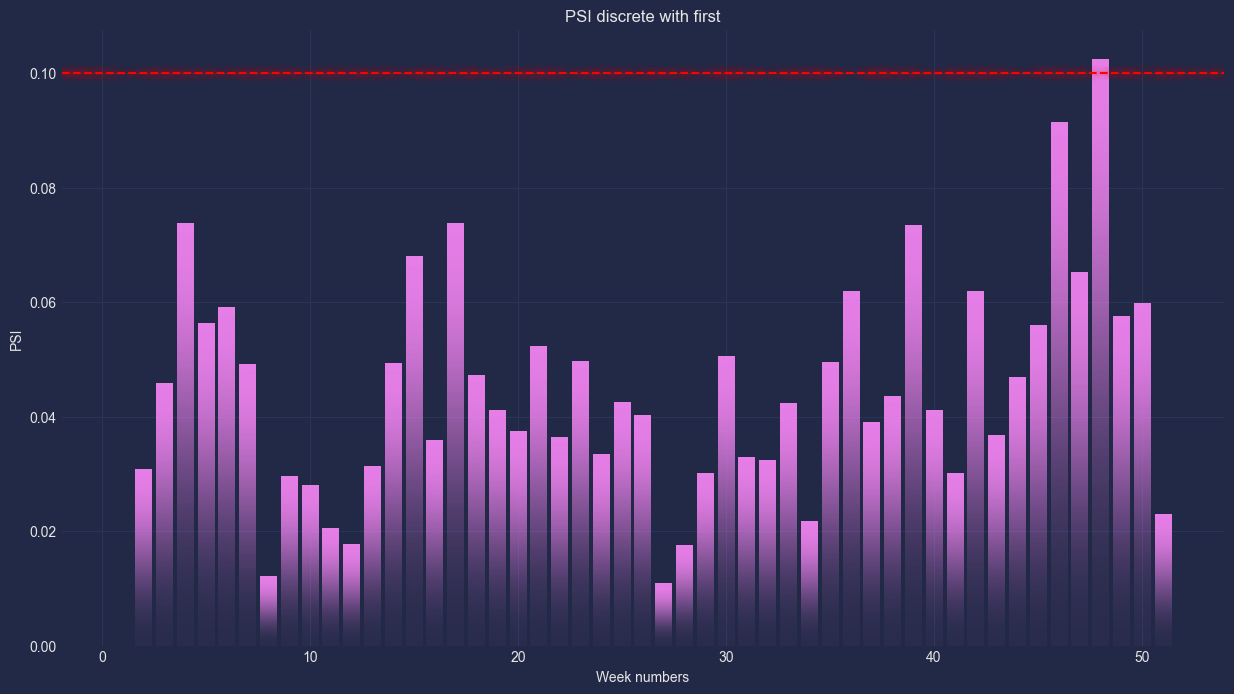

In [15]:
# Визуализация PSI с эталонным сэмплом
plt.figure(figsize=(15, 8))
bars = plt.bar(weeks_disc['week'], weeks_disc['psi_with_first'], color='violet')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.xlabel('Week numbers')
plt.ylabel('PSI')
plt.title('PSI discrete with first')
mplcyberpunk.add_bar_gradient(bars=bars)
mplcyberpunk.make_lines_glow()

### Выводы

В ходе работы был выполнен анализ изменения распределений непрерывной (duration) и дискретной (флаг просмотра фильма в жанре) метрик датасета Netflix audience behaviour - UK movies.
Для этого датасет был сгруппирован по пользователям и определенному году, а сэмплы выбирались по номерам недель.

Факт изменения распределений фиксировался метрикой PSI.

Проведенный анализ показал, следующее:
- при сравнении сэмплов 2-х соседних недель не PSI < 0.1, что говорит о том, что за неделю распределения пользовательских метрик не изменяются так сильно, чтобы критично изменить закон распределения и значени PSI;
- сравнение сэмплов с эталонным распределением (первой неделей в году) показывает, что имеет место накопительный эффект, который приводит в тому, что пиковые значения PSI заметно превышают значения PSI week-by-week;
- сравнение некоторых сэмплов с эталонным показало незначительное превышение PSI значения 0.1, следовательно, необходимо, как минимум, уделить внимание анализу причин изменения закона распределения метрики.